# Lab 08-1: Logistic Regression with TensorFlow
## Exercise: Predicting MNIST Digits

Import TensorFlow

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Test Some TensorFlow codes

### Notice for Implementation with TensorFlow
In the previous classes, we define weight as (n_out, n_in), which leads<br>
h = matmul(w, x.T).T + b., where the first dimension is the batch.<br>
By applying transpose into the parenthesis, we get<br>
h = matmul(x, w.T) + b<br>
Now if we define weight as (n_in, n_out), the linear transformation becomes<br>
h = matmul(x, w) + b<br>

In [ ]:
b = tf.Variable(tf.zeros((100,)))
w = tf.Variable(tf.random.uniform((784, 100)))
x = tf.constant(1., shape=(2, 784))
h = tf.nn.relu(tf.matmul(x, w) + b)

print(b.shape, w.shape, h.shape)

(100,) (784, 100) (2, 100)


In [ ]:
node1 = tf.constant(3.0)
node2 = tf.constant(4.0)
node3 = node1 + node2

print(node3)

tf.Tensor(7.0, shape=(), dtype=float32)


Prepare MNIST Dataset

11501568/11490434 [==============================] - 0s 0us/step


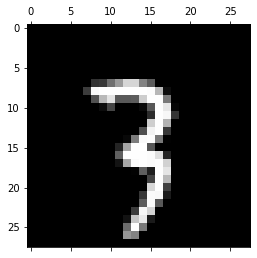

The number is 3


In [ ]:
# Load the original MNIST dataset
# MNIST dataset contains 60000 training images and 10000 test images of 28x28 pixels
# Each image has a hand-written digit
(X_train_org, y_train_num), (X_test_org, y_test) = tf.keras.datasets.mnist.load_data()

idx = np.random.randint(X_test_org.shape[0])
plt.matshow(X_test_org[idx])
plt.gray()
plt.show()
print('The number is', y_test[idx])

# flatten the last dimension for DNN
X_train_org = X_train_org.reshape((X_train_org.shape[0], -1))
X_test_org = X_test_org.reshape(X_test_org.shape[0], -1)

Split training dataset into train and validation

In [ ]:
# Digits data has range of [0,255], which often lead too big exponential values
# so make them normal distribution of [0,1] with the sklearn package, or you can just divide them by 255
X_train = tf.cast(X_train_org / 255, dtype=tf.float32)
X_test = tf.cast(X_test_org / 255, dtype=tf.float32)

# Transform Nx1 Y vector to Nx10 answer vector, so that we can perform one-to-all classification
y_train = tf.one_hot(y_train_num, 10)

# Split training dataset into training and validation
X_val = X_train[50000:60000]
y_val = y_train[50000:60000]

X_train = X_train[:50000]
y_train = y_train[:50000]

n_classes = 10
n_features = 784

Predifined Functions

In [ ]:
def create_mini_batches(X, y, batch_size=64):
    mini_batches = []
    data = np.hstack((X, y))
    np.random.shuffle(data)
    n_classes = y.shape[1]
    n_minibatches = (data.shape[0] // batch_size)
  
    for i in range(n_minibatches):
        mini_batch = data[i * batch_size:(i + 1)*batch_size, :]
        X_mini = mini_batch[:, :-n_classes]
        Y_mini = mini_batch[:, -n_classes:]
        mini_batches.append((X_mini, Y_mini))
    
    if data.shape[0] % batch_size != 0:
        mini_batch = data[n_minibatches * batch_size:data.shape[0]]
        X_mini = mini_batch[:, :-n_classes]
        Y_mini = mini_batch[:, -n_classes:]
        mini_batches.append((X_mini, Y_mini))
        
    return mini_batches

Multi-Class Logistic Regression

In [ ]:
alpha = 0.01

bias = tf.Variable(tf.zeros((n_classes,)))
wegt = tf.Variable(tf.random.uniform((n_features, n_classes))) # define w as (n_feature x n_classes)

n_epochs = 50

for epoch in range(n_epochs):
    # get mini batch
    mini_batches = create_mini_batches(X_train, y_train, batch_size=64)

    for mini_batch in mini_batches:
        X_mini, y_mini = mini_batch
        mb_len = X_mini.shape[0]

        ### START CODE HERE ###
        
        # Forward Prediction Path
        pout = tf.nn.softmax(tf.matmul(X_mini, wegt) + bias)             # Linear Prediction & Softmax

        # Backward Gradient Path
        diff = pout - y_mini             # Find error
        X_tr = tf.transpose(X_mini)             # transpose input for backpropagation
        wegt = wegt - alpha * tf.matmul(X_tr, diff) / mb_len             # update weights with gradient decent
        bias = bias - alpha * tf.reduce_mean(diff, axis=0)             # update bias with gradient decent

    # Just to show progress
    if ((epoch+1)%10==0):
        y_prb = tf.nn.softmax(tf.matmul(X_mini, wegt) + bias)            # forward path
        y_prd = y_mini * tf.math.log(y_prb)            # y * log(y_hat)
        loss_J = -tf.reduce_mean(y_prd).numpy()           # calculate crossentropy, then typecast to numpy

        ### END CODE HERE ###
        print('Epoch: %4d,  loss: %10.8f' % (epoch+1, loss_J))

Epoch:   10,  loss: -0.05188338
Epoch:   20,  loss: -0.03254426
Epoch:   30,  loss: -0.04685844
Epoch:   40,  loss: -0.03023202
Epoch:   50,  loss: -0.02373058


Evaluate

In [ ]:
from sklearn.metrics import accuracy_score

y_prob = tf.nn.softmax(tf.matmul(X_test, wegt) + bias)
y_pred = tf.math.argmax(y_prob, axis=1)

print(y_test[0:10])
print(y_pred[0:10].numpy())

accuracy_score(y_pred, y_test)

[7 2 1 0 4 1 4 9 5 9]
[7 2 1 0 4 1 4 9 6 9]


0.9138

Using GradientTape

In [ ]:
bias = tf.Variable(tf.zeros((n_classes,)))
wegt = tf.Variable(tf.random.uniform((n_features,n_classes)))

# decide optimizer: Gradient Descent with Momentum
opt = tf.optimizers.SGD(learning_rate=0.01)

n_epochs = 50

for epoch in range(n_epochs):
    # get mini batch
    mini_batches = create_mini_batches(X_train, y_train, batch_size=64)

    for mini_batch in mini_batches:
        X_mini, y_mini = mini_batch
        mb_len = X_mini.shape[0]

        # Forward Prediction Path
        with tf.GradientTape() as tape:
            ### START CODE HERE ###

            prob = tf.nn.softmax(tf.matmul(X_mini, wegt) + bias)         # Find Probability
            prod = y_mini * tf.math.log(prob)         # Multiply log odds to ground truth
            loss = -tf.reduce_mean(prod)         # Calculate loss value; do NOT change to numpy
            
            ### END CODE HERE ###

        # Backward Gradient Path
        grad = tape.gradient(loss,[wegt,bias])
        opt.apply_gradients(zip(grad,[wegt,bias]))

    # Just to show progress
    if ((epoch+1)%10==0):
        ### START CODE HERE ###

        y_prb = tf.nn.softmax(tf.matmul(X_mini, wegt) + bias)            # forward path
        y_prd = y_mini * tf.math.log(y_prb)            # y * log(y_hat)
        loss_J = -tf.reduce_mean(y_prd).numpy()           # calculate crossentropy, then typecast to numpy

        ### END CODE HERE ###
        print('Epoch: %4d,  loss: %10.8f' % (epoch+1, loss_J))

Epoch:   10,  loss: 0.10319565
Epoch:   20,  loss: 0.04021993
Epoch:   30,  loss: 0.02826432
Epoch:   40,  loss: 0.07771918
Epoch:   50,  loss: 0.03368280


In [ ]:
from sklearn.metrics import accuracy_score

y_prb = tf.nn.softmax(tf.matmul(X_test, wegt) + bias)
y_prd = tf.math.argmax(y_prb, axis=1)

print(y_test[0:10])
print(y_prd[0:10].numpy())

accuracy_score(y_prd, y_test)

[7 2 1 0 4 1 4 9 5 9]
[7 2 1 0 4 1 4 9 6 9]


0.8603